<a href="https://colab.research.google.com/github/raktim-ghosh/Plant_Disease/blob/master/plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
img_width = 256
img_height = 256
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/train/'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/test/'
train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [0]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [0]:
train_images_dogs_cats.sort(key=natural_keys)
test_images_dogs_cats.sort(key=natural_keys)

In [0]:
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'Scab' in i:
            y.append(1)
        elif 'FrgE' in i:
            y.append(0)
    return x, y

In [6]:
X, Y = prepare_data(train_images_dogs_cats)
print(K.image_data_format())

channels_last


In [0]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=1)

In [0]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
batch_size = 16

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)       

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [12]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/30
59/59 [==============================] - 86s 1s/step - loss: 0.6643 - accuracy: 0.6702 - val_loss: 0.0897 - val_accuracy: 0.9286
Epoch 2/30
59/59 [==============================] - 85s 1s/step - loss: 0.3727 - accuracy: 0.8702 - val_loss: 0.3605 - val_accuracy: 0.8834
Epoch 3/30
59/59 [==============================] - 85s 1s/step - loss: 0.2982 - accuracy: 0.9106 - val_loss: 0.1045 - val_accuracy: 0.9596
Epoch 4/30
59/59 [==============================] - 85s 1s/step - loss: 0.2585 - accuracy: 0.9170 - val_loss: 1.0452 - val_accuracy: 0.5874
Epoch 5/30
59/59 [==============================] - 85s 1s/step - loss: 0.2196 - accuracy: 0.9255 - val_loss: 0.1759 - val_accuracy: 0.9552
Epoch 6/30
59/59 [==============================] - 85s 1s/step - loss: 0.2122 - accuracy: 0.9351 - val_loss: 0.1869 - val_accuracy: 0.8565
Epoch 7/30
59/59 [==============================] - 85s 1s/step - loss: 0.2154 - accuracy: 0.9330 - val_loss: 0.0253 - val_accuracy: 0.9865
Epoch 8/30
59/59 [==

In [0]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [0]:
X_test, Y_test = prepare_data(test_images_dogs_cats)

In [15]:
test_generator = val_datagen.flow(np.array(X_test), batch_size=batch_size)
prediction_probabilities = model.predict_generator(test_generator, verbose=1)

counter = range(1, len(test_images_dogs_cats) + 1)
solution = pd.DataFrame({"id": counter, "label":list(prediction_probabilities)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("dogsVScats.csv", index = False)

4/4 [==============================] - 2s 476ms/step


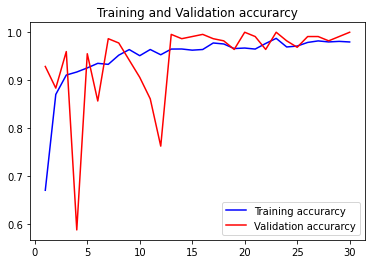

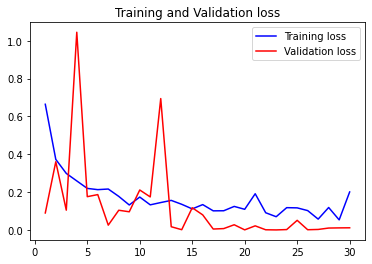

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.savefig('train_val_accuracy.png')

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('train_val_loss.png')
plt.show()